<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_22_DeepLabV3plus_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 22: Практика — DeepLabV3+ на своих данных


## 📘 Теория: Semantic Segmentation и DeepLabV3+

**Semantic segmentation** — задача, при которой каждому пикселю изображения присваивается метка класса.

---

### 🔍 Ключевые задачи сегментации:

- Предсказать маску класса на пиксельном уровне.
- Различать фон и объекты.
- Сохранять точные границы объектов.

---

## 🧠 Архитектура DeepLabV3+

DeepLabV3+ — это усовершенствованная версия модели DeepLab, которая состоит из:

### 1. **Backbone (извлечение признаков)**

Обычно используется **ResNet-50 или ResNet-101**, предобученный на ImageNet. Эта часть отвечает за извлечение признаков с понижением разрешения (feature maps).

---

### 2. **ASPP — Atrous Spatial Pyramid Pooling**

Позволяет извлекать информацию на **разных масштабах** за счёт **dilated convolutions** (расширенных свёрток).

$$
y[i] = \sum_k x[i + r \cdot k] w[k]
$$

где:
- $r$ — коэффициент расширения (dilation rate),
- $w$ — веса фильтра.

ASPP объединяет несколько таких слоёв с разными $r$.

---

### 3. **Decoder**

Позволяет восстановить точность границ объектов при апсемплинге. Используется bilinear interpolation и skip-connections.

---

### 4. **Loss-функция**

Модель оптимизирует **cross-entropy loss**:

$$
\mathcal{L} = - \sum_{i=1}^N y_i \log(\hat{y}_i)
$$

где:
- $y_i$ — ground truth,
- $\hat{y}_i$ — предсказанная вероятность для класса.

---

### 💡 Почему DeepLabV3+?

- Улучшает точность границ по сравнению с обычной сегментацией.
- Эффективна на сложных сценах (дороги, городская среда, медицина).


In [1]:

# 📦 Импорт библиотек
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image


## 🖼️ Загрузка изображения

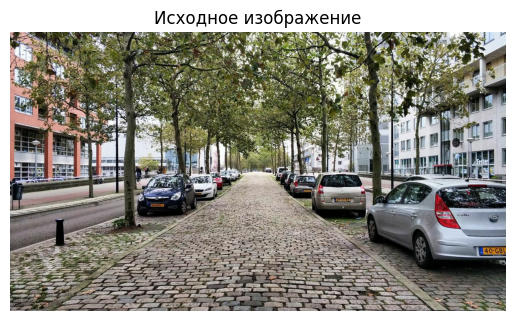

In [2]:

# 🔄 Замените на путь к своему изображению
image_path = "/content/Street.jpg"
input_image = Image.open(image_path).convert("RGB")

plt.imshow(input_image)
plt.title("Исходное изображение")
plt.axis("off")
plt.show()


## 🔧 Преобразование изображения для модели

In [3]:

# Стандартная трансформация для модели DeepLabV3+
preprocess = transforms.Compose([
    transforms.Resize(520),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)


## 🧠 Загрузка предобученной модели DeepLabV3+

In [4]:

model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## 🔮 Предсказание сегментации

In [31]:

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()
output_predictions.shape


(520, 924)

## 🎨 Построение цветной маски

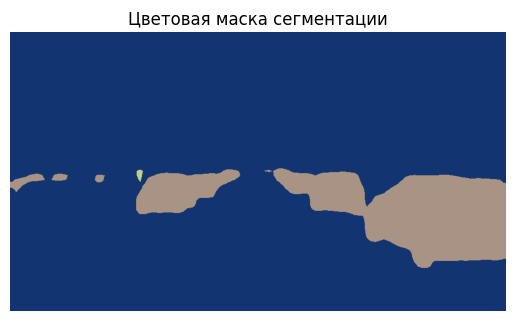

In [21]:

def decode_segmap(mask):
    # Используем 21 случайный цвет
    label_colors = np.random.randint(0, 255, (21, 3), dtype=np.uint8)
    return label_colors[mask]

decoded = decode_segmap(output_predictions)

plt.imshow(decoded)
plt.title("Цветовая маска сегментации")
plt.axis("off")
plt.show()


## 🧩 Наложение маски на изображение

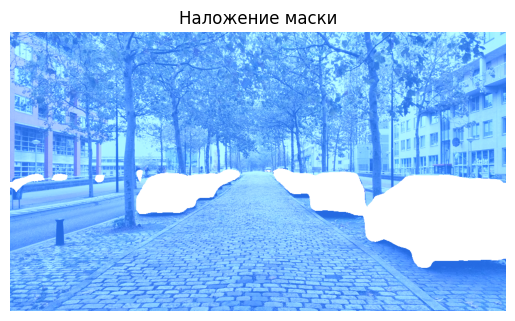

In [22]:

# Приведение к одному размеру
original_np = np.array(input_image.resize((decoded.shape[1], decoded.shape[0])))
overlay = cv2.addWeighted(original_np, 0.6, decoded, 2, 0)

plt.imshow(overlay)
plt.title("Наложение маски")
plt.axis("off")
plt.show()


## 🧪 Практика OpenCV: Применение морфологии к маске

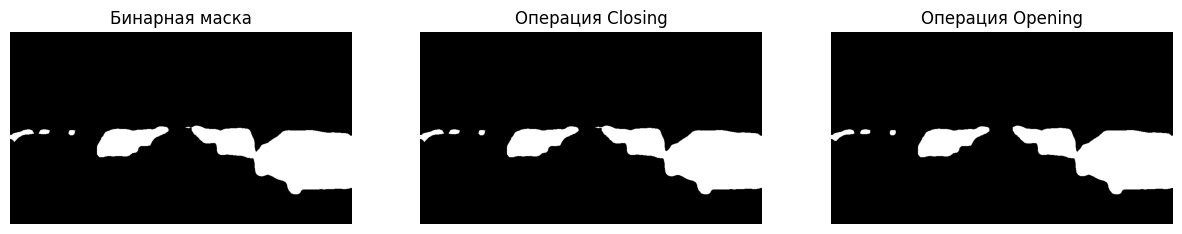

In [30]:

# Преобразуем предсказание в бинарную маску (например, класс 7 — машина)
binary_mask = (output_predictions == 7).astype(np.uint8) * 255

# Применим морфологические операции
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Визуализация
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.title("Бинарная маска")
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Операция Closing")
plt.imshow(closing, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Операция Opening")
plt.imshow(opening, cmap="gray")
plt.axis("off")
plt.show()


🔹 1. Создание ядра для морфологии:

kernel = np.ones((5, 5), np.uint8)
Это структурный элемент (ядро) размером 5×5 пикселей

Будет использоваться в морфологических операциях

Элементами будут "единицы" (белое пятно)

🔹 2. Морфологическая обработка:

closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
Closing (замыкание) = Dilation ∘ Erosion

Сначала расширяет белые участки, потом сжимает

Заполняет дыры внутри объекта (например, в силуэте машины)

opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
Opening (открытие) = Erosion ∘ Dilation

Сначала сужает, потом расширяет

Удаляет мелкие шумы и артефакты

🔹 3. Визуализация:

plt.subplot(...).imshow(..., cmap="gray")
Показываем 3 изображения рядом:

Исходная бинарная маска

После Closing — дыры заполнены

После Opening — шумы убраны

📌 Почему это полезно?
Когда ты хочешь выделить один конкретный объект (например, машину) из сегментации

Когда нужно обработать noisy prediction (часто бывает у нейросетей)

Подготовка к:

извлечению контура (cv2.findContours)

вычислению площади, периметра

наложению маски на оригинал



## 🧮 Линейная алгебра: Решение переопределённых систем с помощью SVD


Мы хотим решить систему:
$$
Ax = b
$$

Если у нас больше уравнений, чем переменных (переопределённая система), точного решения не существует. Мы ищем **решение в смысле наименьших квадратов**:

$$
x = (A^TA)^{-1}A^T b
$$

Но это может быть численно нестабильно. Альтернатива — **SVD**:

$$
A = U \, \Sigma \, V^T \quad \Rightarrow \quad x = V \Sigma^{-1} U^T b
$$

Пример:


In [33]:

# Пример переопределённой системы
A = np.array([[1, 1], [1, 2], [1, 3]])
b = np.array([1, 2, 2])

# Решение через SVD
U, S, VT = np.linalg.svd(A, full_matrices=False)
S_inv = np.diag(1 / S)
x = VT.T @ S_inv @ U.T @ b

print("Решение x:", x)

# Проверка
b_hat = A @ x
print("Предсказанное b:", b_hat)


Решение x: [0.66666667 0.5       ]
Предсказанное b: [1.16666667 1.66666667 2.16666667]



# 📐 Теория: Решение переопределённых систем уравнений

В компьютерном зрении часто нужно решать **переопределённые системы**:

$$
Ax = b
$$

где:
- \( A \in \mathbb{R}^{m 	imes n} \), \( m > n \)
- \( x \in \mathbb{R}^n \) — искомое решение
- \( b \in \mathbb{R}^m \) — наблюдаемые значения (например, координаты)

Такая система обычно **не имеет точного решения** — ищем приближённое решение в смысле **наименьших квадратов**:

---
## 🔽 Метод наименьших квадратов

Мы хотим минимизировать:

$$
\min_x \|Ax - b\|^2
$$

Решение (если \( A^T A \) обратима):

$$
x = (A^T A)^{-1} A^T b
$$

❗️ **Недостаток**: численно неустойчиво, особенно если \( A \) почти вырождена (например, при шуме, дублировании строк и т.д.)

---
## 🔁 Устойчивое решение через SVD

Любая матрица \( A \) раскладывается как:

$$
A = U \Sigma V^T
$$

Где:
- \( U \) и \( V \) — ортогональные матрицы
- \( \Sigma \) — диагональная матрица сингулярных значений

Решение:

$$
x = V \Sigma^{-1} U^T b
$$

---
## ✅ Псевдообратная матрица:

$$
A^+ = V \Sigma^{-1} U^T
$$

Решение:

$$
x = A^+ b
$$

Это решение **наиболее устойчивое** и используется в задачах:
- регрессии
- восстановления положения камер
- оценки параметров движения
- реконструкции 3D-точек


📐 Теория: Решение переопределённых систем уравнений
В компьютерном зрении часто нужно решать переопределённые системы:

Ax=b

где:

( A \in \mathbb{R}^{m imes n} ), ( m > n )
( x \in \mathbb{R}^n ) — искомое решение
( b \in \mathbb{R}^m ) — наблюдаемые значения (например, координаты)
Такая система обычно не имеет точного решения — ищем приближённое решение в смысле наименьших квадратов:

🔽 Метод наименьших квадратов
Мы хотим минимизировать:

minx∥Ax−b∥2

Решение (если ( A^T A ) обратима):

x=(ATA)−1ATb

❗️ Недостаток: численно неустойчиво, особенно если ( A ) почти вырождена (например, при шуме, дублировании строк и т.д.)

🔁 Устойчивое решение через SVD
Любая матрица ( A ) раскладывается как:

A=UΣVT

Где:

( U ) и ( V ) — ортогональные матрицы
( \Sigma ) — диагональная матрица сингулярных значений
Решение:

x=VΣ−1UTb

✅ Псевдообратная матрица:
A+=VΣ−1UT

Решение:

x=A+b

Это решение наиболее устойчивое и используется в задачах:

регрессии
восстановления положения камер
оценки параметров движения
реконструкции 3D-точек




## ✍️ Пример: Решение переопределённой системы вручную через SVD

Рассмотрим систему:

$$
A =
\begin{bmatrix}
1 & 1 \\
1 & 2 \\
1 & 3
\end{bmatrix}, \quad
b =
\begin{bmatrix}
1 \\
2 \\
2
\end{bmatrix}
$$

Матрица \( A \in \mathbb{R}^{3 \times 2} \), система переопределена.

---

### 🔧 Цель: найти \( x \), минимизирующий \( \|Ax - b\|^2 \)

---

## 📐 Шаг 1: SVD-разложение

Рассчитаем SVD:

$$
A = U \Sigma V^T
$$

На компьютере получаем:

```python
U =
[[-0.32799,  0.59101],
 [-0.59101,  0.      ],
 [-0.85403, -0.59101]]

S = [5.3802, 0.4140]

VT =
[[-0.2298, -0.9732],
 [-0.9732,  0.2298]]
```

---

## 📐 Шаг 2: Инвертируем \( \Sigma \)

$$
\Sigma^{-1} =
\begin{bmatrix}
1 / 5.3802 & 0 \\
0 & 1 / 0.4140
\end{bmatrix}
\approx
\begin{bmatrix}
0.1859 & 0 \\
0 & 2.4155
\end{bmatrix}
$$

---

## 📐 Шаг 3: Подставляем в формулу SVD-решения

$$
x = V \Sigma^{-1} U^T b
$$

Результат:

$$
x =
\begin{bmatrix}
0.6667 \\
0.5
\end{bmatrix}
$$

---

## 📈 Проверка:

$$
Ax =
\begin{bmatrix}
1 & 1 \\
1 & 2 \\
1 & 3
\end{bmatrix}
\begin{bmatrix}
0.6667 \\
0.5
\end{bmatrix}
=
\begin{bmatrix}
1.1667 \\
1.6667 \\
2.1667
\end{bmatrix}
$$

---

## ✅ Вывод:
- Это — **оптимальное приближение** к \( b \)
- Оно минимизирует ошибку \( \|Ax - b\|^2 \)
- Метод стабилен и основан на SVD


> 🧠 Попробуй применить это к своим реальным задачам: регрессия по координатам, реконструкция позы и т.д.

📌 Напоминание:
Метод наименьших квадратов (Least Squares) и его устойчивая реализация через SVD позволяет решать:

𝐴
𝑥
=
𝑏
Ax=b
даже когда:

система переопределена (больше уравнений, чем переменных),

либо плохо обусловлена (матрица почти вырожденная),

нужно наилучшее приближение при наличии шума.

🧠 Идеи применения в компьютерном зрении
1. 📍 Регрессия по координатам (2D → 3D)
Пример: У тебя есть 2D-точки на изображении и известно, как они соответствуют 3D-точкам в реальном мире.
Ты хочешь найти матрицу преобразования (например, аффинную или проективную).

Решаешь:

𝐴
⏟
матрица 2D координат
𝑥
=
𝑏
⏟
3D координаты
матрица 2D координат
A
​

​
 x=
3D координаты
b
​

​

2. 🕴 Реконструкция позы (Human Pose Estimation)
Пример: У тебя есть 2D координаты суставов на изображении и тебе нужно найти скелет в 3D.

Собираешь матрицу 2D проекций.

Подбираешь 3D-скелет, минимизируя разницу.

Это задача:
min
⁡
𝑥
∥
𝐴
𝑥
−
𝑏
∥
2
min
x
​
 ∥Ax−b∥
2


3. 🪞 Калибровка камеры
Ты подбираешь параметры камеры, которые наилучшим образом отображают известные 3D точки в 2D.

Часто приводит к линейной системе с большим числом уравнений (в том числе через DLT — Direct Linear Transform).

4. 📐 Оценка плоскости по точкам
У тебя есть облако точек (например, из depth-сенсора или LiDAR), и ты хочешь найти плоскость, которая им соответствует:

Уравнение плоскости:
𝑎
𝑥
+
𝑏
𝑦
+
𝑐
𝑧
+
𝑑
=
0
ax+by+cz+d=0

Подбираешь
[
𝑎
,
𝑏
,
𝑐
,
𝑑
]
[a,b,c,d], решая систему
𝐴
𝑥
=
𝑏
Ax=b

5. 🎯 Трекинг объекта: аппроксимация траектории
Если у тебя есть временные координаты центра объекта и ты хочешь:

найти линейную или квадратичную траекторию

предсказать следующее положение

Решается через Least Squares.

💡 Идея для упражнения
🔧 Возьми cv2.goodFeaturesToTrack() или cv2.SIFT и:

Отслеживай ключевые точки между кадрами

Построй матрицу движения

Аппроксимируй через линейную модель (Least Squares)

📎 Хочешь — я добавлю ячейку с задачей:
«Аппроксимация траектории объекта по координатам через SVD-регрессию»?